### 1 Introduction and Setup
#### 1.1 Introduction

In this notebook the objetive is to make a data enrichment using ImdbId throw dataset links and in this way create more interesting queries and insigths to our dataset.

The point of connection of both database will be the table "link" that contais for each movieId a link number to Imdb movie primary key tconst. With this structure is possible to acess to writers, directors and actors of the diferent movies. 

The new Imdb FIles will be transformed in parquet files, and since this IMdb file contains a huge amount of information initially for the existing files only a view table will be created instead of table. The reason for that is that is not interesting to created huge table and only query in small percentage of Imdb movies of the dataset. In this way 1st it will be created a view over the Imdb table and only after making a left join with movienls link a table withe the result will be created.

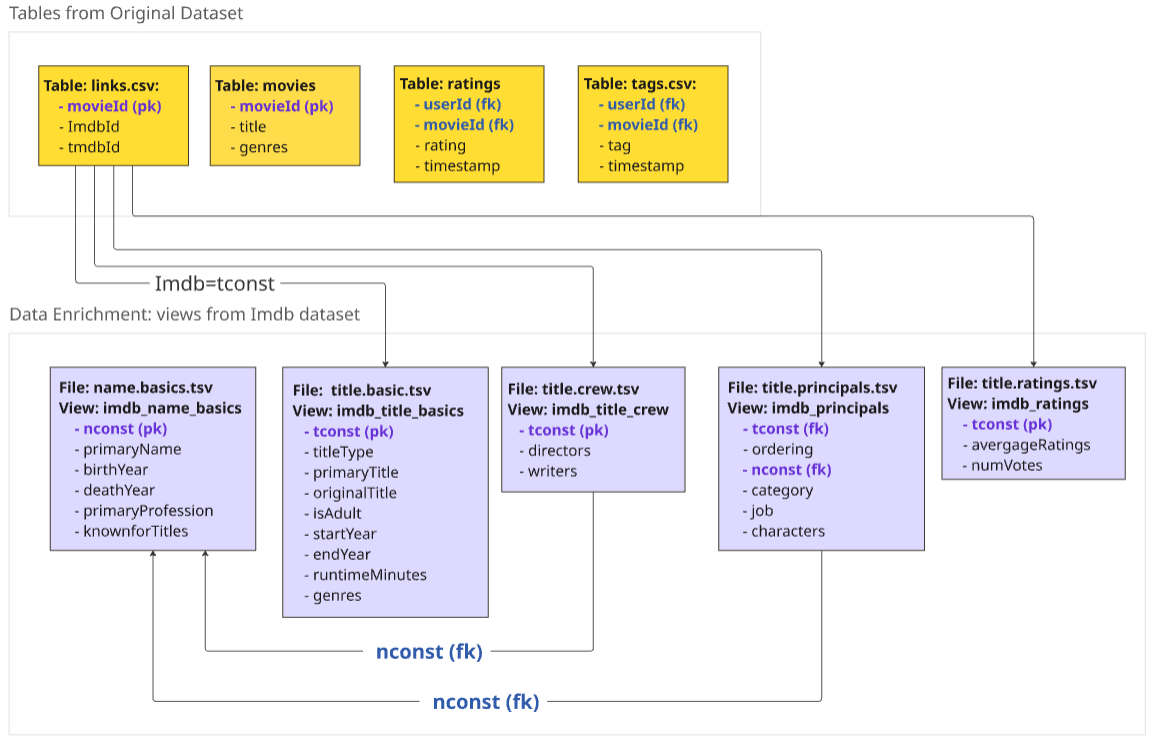

#### 1.2 Library and duckdb file import

In [1]:
#================================================
# DATA
#================================================

import duckdb, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os

# creating the conection to the duckdb database file:
con = duckdb.connect("movielensfull33M.duckdb")

In [2]:
IMDB_DIR = Path("..") / "data" / "Imdb"
IMDB_DIR

WindowsPath('../data/Imdb')

### 2 Converting to parquet and creating temporary Views to query Imdb File composition
#### 2.1 Creation parquet file and view of File "name.basics.tsv"

In [3]:
#Creating parquet file

parquet_file = IMDB_DIR / "name.basics.parquet"
tsv_file = IMDB_DIR / "name.basics.tsv"

# Delete old parquet if needed
if parquet_file.exists():
    os.remove(parquet_file)

duckdb.sql(f"""
COPY (
    SELECT *
    FROM read_csv_auto(
        '{tsv_file}',
        delim='\t',
        header=TRUE,
        nullstr='\\N'
    )
) TO '{parquet_file}' (FORMAT 'parquet');
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
con.sql(f"""
CREATE OR REPLACE VIEW imdb_name_basics AS
SELECT *
FROM read_parquet('{IMDB_DIR / "name.basics.parquet"}')
""")


In [5]:
# Reviewing the structure of the imdb_name_basics table
con.sql("DESCRIBE imdb_name_basics").df()


,column_name,column_type,null,key,default,extra
0,nconst,VARCHAR,YES,None,None,None
1,primaryName,VARCHAR,YES,None,None,None
2,birthYear,BIGINT,YES,None,None,None
3,deathYear,BIGINT,YES,None,None,None
4,primaryProfession,VARCHAR,YES,None,None,None
5,knownForTitles,VARCHAR,YES,None,None,None


In [6]:
# Reviewing some data from the imdb_name_basics table
con.sql("SELECT * FROM imdb_name_basics LIMIT 3").df()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0025164"
1,nm0000002,Lauren Bacall,1924,2014,"actress,miscellaneous,soundtrack","tt0037382,tt0075213,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934,<NA>,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"


In [7]:
# count of the number of distinct professions in the table and diferent profissions in the dataset
professions_df=con.sql("""
        WITH all_professions AS (
        SELECT UNNEST(str_split(primaryProfession, ',')) AS profession 
        FROM imdb_name_basics
    ),
    count_professions AS (
        SELECT COUNT(DISTINCT profession) AS distinct_professions
        FROM all_professions
    ),
    professions_stats AS (
        SELECT profession,
        COUNT(*) AS total
    FROM all_professions
    GROUP BY profession
    ),
    union_table AS (
    
    SELECT
        'TOTAL_DISTINCT_PROFESSIONS' AS profession,
        (SELECT distinct_professions FROM count_professions) AS total
    UNION ALL
    SELECT
        profession,
        total
    FROM professions_stats
    )
    SELECT *
    FROM union_table
    ORDER BY
        CASE WHEN profession = 'TOTAL_DISTINCT_PROFESSIONS' THEN 0 ELSE 1 END,
        total DESC
    --LIMIT 15
 """).df()

professions_df

,profession,total
0,TOTAL_DISTINCT_PROFESSIONS,46
1,actor,3412934
2,actress,2062425
3,miscellaneous,1338806
4,producer,1309116
5,writer,981441
6,camera_department,870867
7,director,802905
8,art_department,486831
9,cinematographer,430325


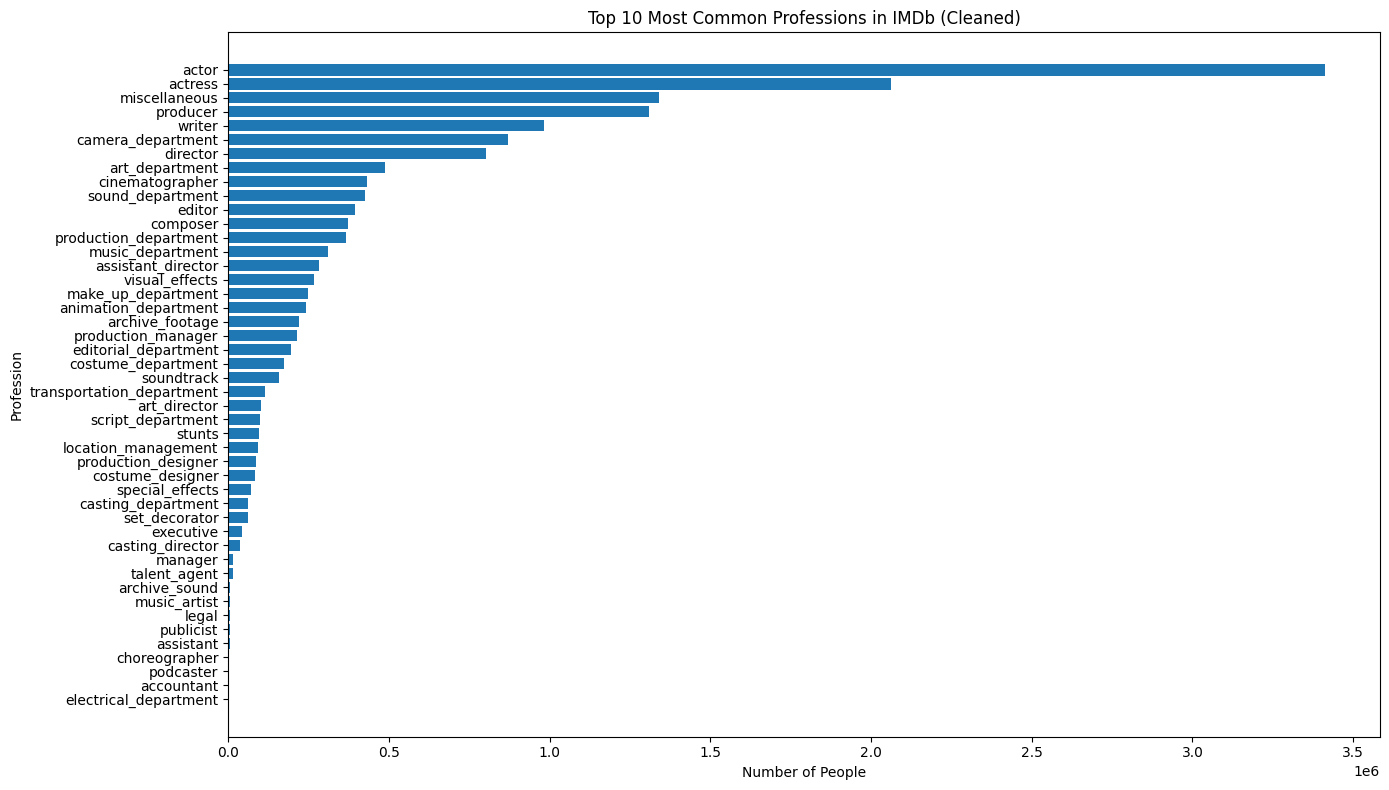

In [8]:
# Making a bar graph with query results

professions_df = professions_df.iloc[1:]

plt.figure(figsize=(14, 8))
plt.barh(professions_df["profession"], professions_df["total"])
plt.xlabel("Number of People")
plt.ylabel("Profession")
plt.title("Top 10 Most Common Professions in IMDb (Cleaned)")
plt.gca().invert_yaxis()  # Maior valor no topo
plt.tight_layout()
plt.show()

Comment:

This table, imdb_name_basics, contains the primary key nconst and the names of the people who take part in different films. It also includes the professions associated with each person (around 46 different ones). The primary key nconst makes it possible to link the films in the database with the people involved and the specific role/profession they performed in each film.

#### 2.2 Creation parquet file and view of File "title.basics.tsv"

In [9]:
#Creating parquet file

parquet_file = IMDB_DIR / "title.basics.parquet"
tsv_file = IMDB_DIR / "title.basics.tsv"

# Delete old parquet if needed
if parquet_file.exists():
    os.remove(parquet_file)

duckdb.sql(f"""
COPY (
    SELECT *
    FROM read_csv_auto(
        '{tsv_file}',
        delim='\t',
        header=TRUE,
        nullstr='\\N'
    )
) TO '{parquet_file}' (FORMAT 'parquet');
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [10]:
# Creating the view
con.sql(f"""
CREATE OR REPLACE VIEW imdb_title_basics AS
SELECT *
FROM read_parquet('{IMDB_DIR / "title.basics.parquet"}')
""")

In [11]:
# Reviewing the structure of the imdb_title_basics table
con.sql("describe imdb_title_basics").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,titleType,VARCHAR,YES,None,None,None
2,primaryTitle,VARCHAR,YES,None,None,None
3,originalTitle,VARCHAR,YES,None,None,None
4,isAdult,BIGINT,YES,None,None,None
5,startYear,BIGINT,YES,None,None,None
6,endYear,VARCHAR,YES,None,None,None
7,runtimeMinutes,BIGINT,YES,None,None,None
8,genres,VARCHAR,YES,None,None,None


In [12]:
# Reviewing some data from the imdb_title_basics table
con.sql("SELECT * FROM imdb_title_basics LIMIT 3").df()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,None,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,None,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,None,5,"Animation,Comedy,Romance"


In [13]:
# How many films does this Db has
con.sql("""
SELECT COUNT(DISTINCT tconst) AS total_titles
FROM imdb_title_basics
""").df()

,total_titles
0,12046631


Comment:

This table contains basic information about the movie base ont he primary key "tconst". In this way is possible to acesso the Movies name, year of launch, runtime and the genres.

#### 2.3 Creation parquet file and view of File "title.crew.tsv"

In [14]:
#Creating parquet file

parquet_file = IMDB_DIR / "title.crew.parquet"
tsv_file = IMDB_DIR / "title.crew.tsv"

# Delete old parquet if needed
if parquet_file.exists():
    os.remove(parquet_file)

duckdb.sql(f"""
COPY (
    SELECT *
    FROM read_csv_auto(
        '{tsv_file}',
        delim='\t',
        header=TRUE,
        nullstr='\\N'
    )
) TO '{parquet_file}' (FORMAT 'parquet');
""")

In [15]:
con.sql(f"""
CREATE OR REPLACE VIEW imdb_title_crew AS
SELECT *
FROM read_parquet('{IMDB_DIR / "title.crew.parquet"}')
""")

In [16]:
# Reviewing the structure of the imdb_title_crew table
con.sql("DESCRIBE imdb_title_crew").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,directors,VARCHAR,YES,None,None,None
2,writers,VARCHAR,YES,None,None,None


In [17]:
# Reviewing some data from the imdb_title_crew table
con.sql("SELECT * FROM imdb_title_crew LIMIT 3").df()

,tconst,directors,writers
0,tt0000001,nm0005690,None
1,tt0000002,nm0721526,None
2,tt0000003,nm0721526,nm0721526


In [18]:
# How many diferent directors and writers this DB has
con.sql("""
SELECT COUNT(DISTINCT tconst) AS titles_count,COUNT(DISTINCT directors) AS directors_count, COUNT(DISTINCT writers) AS writers_count
FROM imdb_title_crew
""").df()

,titles_count,directors_count,writers_count
0,12048919,983104,1461632


Comment:

This table contains basic information about the movie crew: director and writer. With the movieId key 'tconst' is possible to get the foreign key of the director and writer name.

#### 2.4 Creation of parquet file and view from File "title.principals.tsv"
##### 2.4.1 General exploration

In [19]:
#Creating parquet file
parquet_file = IMDB_DIR / "title.principals.parquet"
tsv_file = IMDB_DIR / "title.principals.tsv"

# Delete old parquet if needed
if parquet_file.exists():
    os.remove(parquet_file)

duckdb.sql(f"""
COPY (
    SELECT *
    FROM read_csv_auto(
        '{tsv_file}',
        delim='\t',
        header=TRUE,
        nullstr='\\N'
    )
) TO '{parquet_file}' (FORMAT 'parquet');
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [20]:
con.sql(f"""
CREATE OR REPLACE VIEW imdb_principals AS
SELECT *
FROM read_parquet('{IMDB_DIR / "title.principals.parquet"}')
""")

In [21]:
# Reviewing the structure of the imdb_principals table
con.sql("DESCRIBE imdb_principals").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,ordering,BIGINT,YES,None,None,None
2,nconst,VARCHAR,YES,None,None,None
3,category,VARCHAR,YES,None,None,None
4,job,VARCHAR,YES,None,None,None
5,characters,VARCHAR,YES,None,None,None


In [22]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM imdb_principals LIMIT 10").df()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,None,"[""Self""]"
1,tt0000001,2,nm0005690,director,None,None
2,tt0000001,3,nm0005690,producer,producer,None
3,tt0000001,4,nm0374658,cinematographer,director of photography,None
4,tt0000002,1,nm0721526,director,None,None
5,tt0000002,2,nm1335271,composer,None,None
6,tt0000003,1,nm0721526,director,None,None
7,tt0000003,2,nm0721526,writer,None,None
8,tt0000003,3,nm1770680,producer,producer,None
9,tt0000003,4,nm0721526,producer,producer,None


##### 2.4.2 Creation of table view with movies ID (imdb and movielens)

In [23]:
con.sql("SHOW TABLES").df()

,name
0,imdb_map_ids
1,imdb_name_basics
2,imdb_principals
3,imdb_principals_writers
4,imdb_ratings
5,imdb_title_basics
6,imdb_title_crew
7,links
8,movielens_actors
9,movielens_directors


In [24]:
# Df Creation with link between movielens and Imdb links
con.sql("""
CREATE OR REPLACE VIEW imdb_map_ids AS
SELECT
    movieId,
    'tt' || LPAD(imdbId, 7, '0') AS tconst
FROM links
WHERE imdbId IS NOT NULL;
""")

In [25]:
# Reviewing some data from the imdbmaps_ids table
con.sql("SELECT * FROM imdb_map_ids LIMIT 10").df()

,movieId,tconst
0,1,tt0114709
1,2,tt0113497
2,3,tt0113228
3,4,tt0114885
4,5,tt0113041
5,6,tt0113277
6,7,tt0114319
7,8,tt0112302
8,9,tt0114576
9,10,tt0113189


In [26]:
# Count of the different categories and number of occurrences of each one
con.sql("""
    SELECT
        p.category,
        COUNT(*) AS total
    FROM imdb_principals AS p
    JOIN imdb_map_ids AS map
        ON p.tconst = map.tconst  
    JOIN movies AS m
        ON m.movieId = map.movieId
    GROUP BY p.category
    ORDER BY total DESC;
""").df()

,category,total
0,actor,469115
1,actress,250904
2,writer,154946
3,producer,133643
4,editor,90687
5,director,89632
6,cinematographer,82655
7,composer,79220
8,self,55675
9,casting_director,46670


In [27]:
# How many MovieLens movies have link to imdbId?
con.sql("""
SELECT COUNT(*) AS movielens_movies_count,
       COUNT(imdbId) AS movies_with_link,
       COUNT(*) - COUNT(imdbId) AS movies_without_link
FROM links
""").df()


,movielens_movies_count,movies_with_link,movies_without_link
0,86537,86537,0


In [28]:
# Count of the different jobs and number of occurrences of each one
con.sql("""
    SELECT
        p.job,
        COUNT(*) AS total
    FROM imdb_principals AS p
    JOIN imdb_map_ids AS map
        ON p.tconst = map.tconst        -- Link IMDb tconst -> MovieLens movieId
    JOIN movies AS m
        ON m.movieId = map.movieId      -- Ensure the movie exists in MovieLens
    GROUP BY p.job
    ORDER BY total DESC
    LIMIT 30;
""").df()


,job,total
0,None,1159427
1,producer,129050
2,screenplay,26105
3,written by,23725
4,director of photography,21659
5,composer,14948
6,writer,14010
7,editor,12100
8,director,11656
9,story,11208


##### 2.4.2 category=producer in "imdb_principals" view 

In [29]:
# Count wich and how many times jobs appears for category = 'producer'
df_job_top = con.execute("""
    SELECT
        p.job,
        COUNT(*) AS job_count
    FROM imdb_principals AS p
    JOIN imdb_map_ids AS map
        ON p.tconst = map.tconst        -- link IMDb title to MovieLens movieId
    JOIN movies AS m
        ON m.movieId = map.movieId      -- ensure the movie exists in MovieLens
    WHERE p.category = 'producer'
      AND p.job IS NOT NULL             -- ignore NULL jobs (optional)
    GROUP BY p.job
    ORDER BY job_count DESC
    LIMIT 20;
""").df()

df_job_top



,job,job_count
0,producer,129049
1,executive producer,3852
2,line producer,444
3,associate producer,104
4,planner,34
5,creative producer,13
6,field producer,11
7,development executive,9
8,assistant producer,6
9,consulting producer,5


##### 2.4.3 category=writer in "imdb_principals" view

In [30]:
# Count wich and how many times jobs appears for category = 'writer'
df_job_top = con.execute("""
    SELECT
        p.job,
        COUNT(*) AS job_count
    FROM imdb_principals AS p
    JOIN imdb_map_ids AS map
        ON p.tconst = map.tconst        -- link IMDb title to MovieLens movieId
    JOIN movies AS m
        ON m.movieId = map.movieId      -- ensure the movie exists in MovieLens
    WHERE p.category = 'writer'
      AND p.job IS NOT NULL             -- ignore NULL jobs (optional)
    GROUP BY p.job
    ORDER BY job_count DESC
    LIMIT 25;
""").df()

df_job_top


,job,job_count
0,screenplay,26105
1,written by,23725
2,writer,14010
3,story,11208
4,screenplay by,3902
5,novel,3896
6,adaptation,2071
7,screen play,1836
8,dialogue,1765
9,story by,1730


##### 2.4.4 category=Director in "imdb_principals" view

In [31]:
# Count wich and how many times jobs appears for category = 'director'
df_job_top = con.execute("""
    SELECT
        p.job,
        COUNT(*) AS job_count
    FROM imdb_principals AS p
    JOIN imdb_map_ids AS map
        ON p.tconst = map.tconst        -- link IMDb title to MovieLens movieId
    JOIN movies AS m
        ON m.movieId = map.movieId      -- ensure movie exists in MovieLens dataset
    WHERE p.category = 'director'
      AND p.job IS NOT NULL             -- ignore NULL jobs (optional)
    GROUP BY p.job
    ORDER BY job_count DESC
    LIMIT 20;
""").df()

df_job_top

,job,job_count
0,director,11654
1,supervising director,124
2,segment director,74
3,series director,59
4,chief director,44
5,sequence director,43
6,collaborating director,25
7,voice director,25
8,creative director,23
9,documentary director,20


#### 2.5 Creation of parquet file and view from File "title.ratings.tsv"

In [32]:
#Creating parquet file
parquet_file = IMDB_DIR / "title.ratings.parquet"
tsv_file = IMDB_DIR / "title.ratings.tsv"

# Delete old parquet if needed
if parquet_file.exists():
    os.remove(parquet_file)

duckdb.sql(f"""
COPY (
    SELECT *
    FROM read_csv_auto(
        '{tsv_file}',
        delim='\t',
        header=TRUE,
        nullstr='\\N'
    )
) TO '{parquet_file}' (FORMAT 'parquet');
""")

In [33]:
con.sql(f"""
CREATE OR REPLACE VIEW imdb_ratings AS
SELECT *
FROM read_parquet('{IMDB_DIR / "title.ratings.parquet"}')
""")

In [34]:
# Reviewing the structure of the imdb_ratings table
con.sql("DESCRIBE imdb_ratings").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,averageRating,DOUBLE,YES,None,None,None
2,numVotes,BIGINT,YES,None,None,None


In [35]:
# Reviewing some data from the imdb_ratings table
con.sql("SELECT * FROM imdb_ratings LIMIT 5").df()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2183
1,tt0000002,5.5,304
2,tt0000003,6.4,2263
3,tt0000004,5.2,195
4,tt0000005,6.2,3006


In [36]:
# Some statistics about the ratings and votes
con.sql("""
SELECT
    COUNT(*)                        AS total_filmes,
    MIN(averageRating)              AS min_rating,
    MAX(averageRating)              AS max_rating,
    AVG(averageRating)              AS media_rating,
    MIN(numVotes)                   AS min_votes,
    MAX(numVotes)                   AS max_votes,
    AVG(numVotes)                   AS media_votes
FROM imdb_ratings
""").df()

,total_filmes,min_rating,max_rating,media_rating,min_votes,max_votes,media_votes
0,1634484,1.0,10.0,6.928612,5,3116740,1017.511738


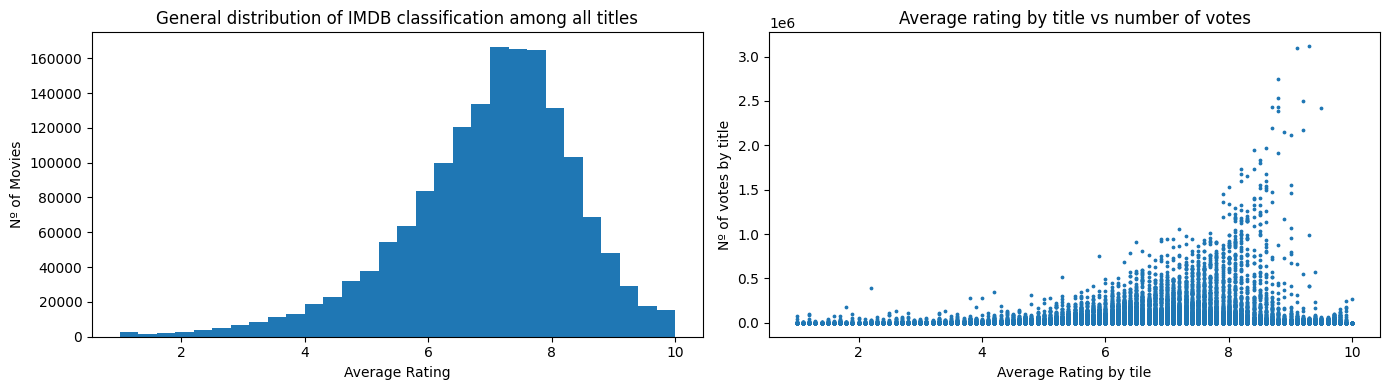

In [37]:
# Visualizing the distribution of ratings and votes
df_ratings = con.sql("SELECT averageRating FROM imdb_ratings").df()
df_votes   = con.sql("SELECT numVotes, averageRating FROM imdb_ratings WHERE numVotes < 50000000000").df()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,4))

# --- gráfic 1: hist rating
axes[0].hist(df_ratings["averageRating"], bins=30)
axes[0].set_title("General distribution of IMDB classification among all titles")
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Nº of Movies")

# --- gráfico 2: scatter
axes[1].scatter(df_votes["averageRating"], df_votes["numVotes"], s=3)
axes[1].set_title("Average rating by title vs number of votes")
axes[1].set_xlabel("Average Rating by tile")
axes[1].set_ylabel("Nº of votes by title")

plt.tight_layout()
plt.show()


#### 2.6 Summary of Imdb info

At the end of this chapter the existing views have been created and some exploratory queries have been made over this views, the time to consult and extract information until now its not relevant until now. In the next step we will create the new tables.

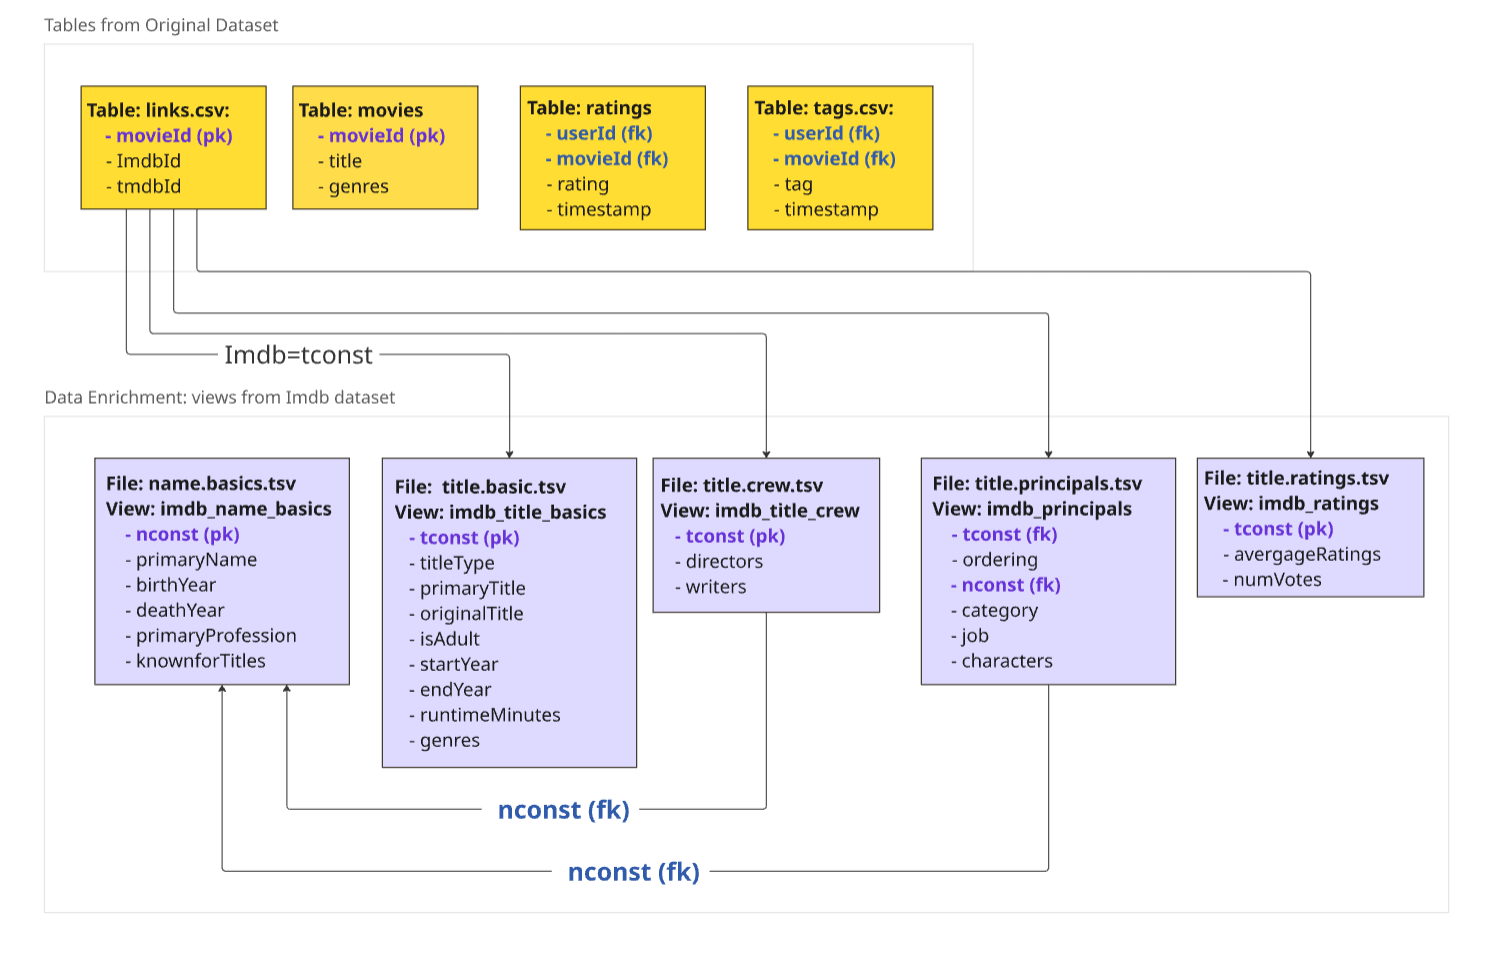

In [38]:
# List of all tables in the database
con.sql("""
SELECT table_name, table_type
FROM information_schema.tables
""").df()

,table_name,table_type
0,imdb_principals_writers,BASE TABLE
1,links,BASE TABLE
2,movielens_actors,BASE TABLE
3,movielens_directors,BASE TABLE
4,movielens_main_producers,BASE TABLE
5,movielens_ratings_imdb,BASE TABLE
6,movielens_writers,BASE TABLE
7,movies,BASE TABLE
8,ratings,BASE TABLE
9,tags,BASE TABLE


### 3 Data enrichment with Imdb dataset

#### 3.1 Objetive

The objetive of this chapter is to creat the following new tables so the acess is faster to querie

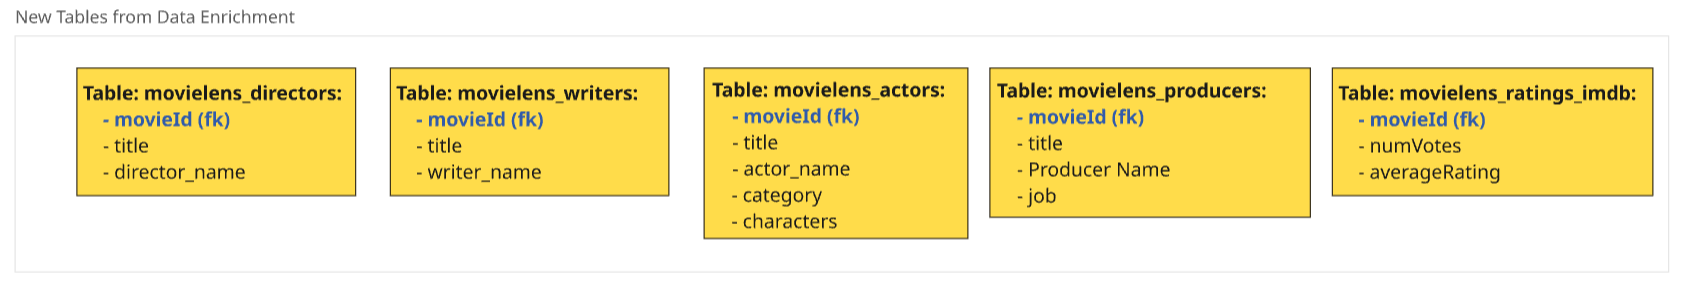

#### 3.2 Creation of table with movielens movie Directors

Para apagar

 Creation of table movielens_directors
con.sql("""
CREATE OR REPLACE TABLE movielens_directors AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName AS director_name
FROM movies AS m
JOIN imdb_map_ids AS map ON map.movieId = m.movieId
JOIN imdb_title_crew AS c ON c.tconst = map.tconst
-- explode comma-separated directors into rows
--CROSS JOIN UNNEST(str_split(c.directors, ',')) AS d(director_nconst_raw)

        
LEFT JOIN imdb_name_basics AS nb
    ON nb.nconst = TRIM(d.director_nconst_raw)
WHERE c.directors IS NOT NULL
  AND c.directors <> '';
""")

con.sql("""
CREATE OR REPLACE TABLE movielens_directors AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName AS director_name
FROM movies AS m
JOIN imdb_map_ids AS map
    ON map.movieId = m.movieId
JOIN imdb_title_crew AS c
    ON c.tconst = map.tconst
LEFT JOIN imdb_name_basics AS nb
    ON nb.nconst = TRIM(str_split(c.directors, ',')[1])
WHERE c.directors IS NOT NULL
  AND c.directors <> '';
""")

In [39]:
# Creation of table movielens_directors

con.sql("""
CREATE OR REPLACE TABLE movielens_directors AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName AS director_name
FROM movies AS m
JOIN imdb_map_ids AS map ON map.movieId = m.movieId
JOIN imdb_title_crew AS c ON c.tconst = map.tconst
-- explode comma-separated directors into rows
CROSS JOIN UNNEST(str_split(c.directors, ',')) AS d(director_nconst_raw)
LEFT JOIN imdb_name_basics AS nb
    ON nb.nconst = TRIM(d.director_nconst_raw)
WHERE c.directors IS NOT NULL
  AND c.directors <> '';
""")


In [40]:
# Query: count distinct and non-distinct movieId values
df_counts = con.execute("""
    SELECT
        COUNT(movieId) AS total_rows,              -- non-distinct
        COUNT(DISTINCT movieId) AS distinct_rows   -- distinct
    FROM movielens_directors;
""").df()

print(df_counts)

   total_rows  distinct_rows
0       95707          83360


In [41]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_directors LIMIT 5").df()

,movieId,title,director_name
0,163807,The Most Beautiful Day (2016),Florian David Fitz
1,178113,Filth City (2017),Andy King
2,170629,The Discovery (2017),Charlie McDowell
3,201841,Cardboard Gangsters (2017),Mark O'Connor
4,230385,Fanarchy (2015),Donna Davies


In [42]:
# Query to determine how many films from our original dataset find a match for their director here, and how many do not.
con.sql("""
WITH t AS (
    SELECT COUNT(*) AS total_movies FROM movies
),
d AS (
    SELECT COUNT(DISTINCT movieId) AS movies_with_director
    FROM movielens_directors
)
SELECT
    t.total_movies,
    d.movies_with_director,
    t.total_movies - d.movies_with_director AS movies_without_director
FROM t, d;
""").df()

,total_movies,movies_with_director,movies_without_director
0,86537,83360,3177


In [43]:
top_directors = con.sql("""
SELECT
    director_name,
    COUNT(*) AS total_movies
FROM movielens_directors
WHERE director_name IS NOT NULL
GROUP BY director_name
ORDER BY total_movies DESC
LIMIT 10;
""").df()

top_directors


,director_name,total_movies
0,Georges Méliès,116
1,Friz Freleng,111
2,Chuck Jones,108
3,Tex Avery,89
4,Michael Curtiz,84
5,Jean-Luc Godard,75
6,John Ford,73
7,Richard Thorpe,71
8,Jack Hannah,66
9,Jack Kinney,65


In [44]:
# Compute mean, median and mode of number of directors per film
con.sql("""
WITH director_counts AS (
    SELECT
        movieId,
        COUNT(*) AS num_directors
    FROM movielens_directors
    GROUP BY movieId
),
mode_calc AS (
    SELECT
        num_directors,
        COUNT(*) AS freq,
        ROW_NUMBER() OVER (ORDER BY COUNT(*) DESC) AS rn
    FROM director_counts
    GROUP BY num_directors
)
SELECT
    AVG(num_directors) AS mean_directors,
    MEDIAN(num_directors) AS median_directors,
    (SELECT num_directors FROM mode_calc WHERE rn = 1) AS mode_directors
FROM director_counts
        """).df()

,mean_directors,median_directors,mode_directors
0,1.148117,1.0,1


#### 3.3 Creation of table with movielens movie Writers

Creation of table movielens_writers

con.sql("""
CREATE OR REPLACE TABLE movielens_writers AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName AS writer_name
FROM movies AS m
JOIN imdb_map_ids AS map
    ON map.movieId = m.movieId
JOIN imdb_title_crew AS c
    ON c.tconst = map.tconst
CROSS JOIN UNNEST(str_split(c.writers, ',')) AS d(writer_nconst_raw)
LEFT JOIN imdb_name_basics AS nb
    ON nb.nconst = TRIM(d.writer_nconst_raw)
WHERE c.writers IS NOT NULL
  AND c.writers <> ''
  AND c.writers <> '\\N';
""")

In [45]:
con.sql("""
CREATE OR REPLACE TABLE movielens_writers AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName AS writer_name
FROM movies AS m
JOIN imdb_map_ids AS map
    ON map.movieId = m.movieId
JOIN imdb_title_crew AS c
    ON c.tconst = map.tconst
LEFT JOIN imdb_name_basics AS nb
    ON nb.nconst = TRIM(str_split(c.writers, ',')[1])
WHERE c.writers IS NOT NULL
  AND c.writers <> ''
  AND c.writers <> '\\N';
""")


In [46]:
# Query: count distinct and non-distinct movieId values
df_counts = con.execute("""
    SELECT
        COUNT(movieId) AS total_rows,              -- non-distinct
        COUNT(DISTINCT movieId) AS distinct_rows   -- distinct
    FROM movielens_writers;
""").df()

print(df_counts)

   total_rows  distinct_rows
0       78330          78330


In [47]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_writers LIMIT 5").df()

,movieId,title,writer_name
0,201292,Chocolate (2005),Mick Garris
1,196659,Dance of the Dead (2005),Mick Garris
2,201318,Deer Woman (2005),Mick Garris
3,201262,Dreams in the Witch House (2005),Mick Garris
4,201294,Homecoming (2005),Mick Garris


In [48]:
# Query to determine writers with more movies in the dataset
top_writers = con.sql("""
SELECT
    writer_name,
    COUNT(*) AS total_movies
FROM movielens_writers
WHERE writer_name IS NOT NULL
GROUP BY writer_name
ORDER BY total_movies DESC
LIMIT 10;
""").df()

top_writers


,writer_name,total_movies
0,William Shakespeare,83
1,Michael Maltese,81
2,Charles Chaplin,68
3,Stephen King,60
4,Woody Allen,54
5,Tedd Pierce,53
6,Warren Foster,50
7,Werner Herzog,49
8,Ingmar Bergman,48
9,Franco Castellano,44


In [49]:
# Coverage: how many ML movies have at least one writer mapped vs not
con.sql("""
WITH t AS (
    SELECT COUNT(*) AS total_movies FROM movies
),
w AS (
    SELECT COUNT(DISTINCT movieId) AS movies_with_writer
    FROM movielens_writers
)
SELECT
    t.total_movies,
    w.movies_with_writer,
    t.total_movies - w.movies_with_writer AS movies_without_writer
FROM t, w;
""").df()

,total_movies,movies_with_writer,movies_without_writer
0,86537,78330,8207


In [50]:
# Movies with more than one writer (list names if you want)
con.sql("""
SELECT
    movieId,
    title,
    COUNT(DISTINCT writer_name) AS num_writers
FROM movielens_writers
GROUP BY movieId, title
HAVING COUNT(DISTINCT writer_name) > 1
ORDER BY num_writers DESC, title;
""").df()

,movieId,title,num_writers


Comment:

This table show 32 writers of the movie "mulan", what seems to that does not make sense: after visiting IMDB page is undertanded that there are several diferent writers but only one general wrting. 

link: https://www.imdb.com/title/tt0120762/fullcredits/?ref_=tt_ov_sm_2#amzn1.imdb.concept.name_credit_category.c84ecaff-add5-4f2e-81db-102a41881fe3
 

In [51]:
# Create a table with writers based on imdb_principals (category = 'writer')
con.sql("""
    CREATE OR REPLACE TABLE imdb_principals_writers AS
    SELECT
        m.movieId,
        m.title,
        nb.primaryName AS writer_name,
        p.job
    FROM movies AS m
    JOIN imdb_map_ids AS map
        ON map.movieId = m.movieId          -- Link MovieLens -> IMDb (tconst)
    JOIN imdb_principals AS p
        ON p.tconst = map.tconst            -- Use IMDb title id
    JOIN imdb_name_basics AS nb
        ON nb.nconst = p.nconst             -- Get writer's name
    WHERE p.category = 'writer';
""")


In [52]:
# Check row counts for both tables
con.sql("SELECT 'movielens_writers' AS table_name, COUNT(*) AS row_count FROM movielens_writers UNION ALL SELECT 'imdb_principals_writers', COUNT(*) FROM imdb_principals_writers").df()


,table_name,row_count
0,movielens_writers,78330
1,imdb_principals_writers,154942


In [53]:
# Writers present in imdb_principals_writers but missing in movielens_writers
df_only_principals = con.execute("""
    SELECT 
        ipw.movieId,
        ipw.title,
        ipw.writer_name,
        ipw.job
    FROM imdb_principals_writers AS ipw
    LEFT JOIN movielens_writers AS mw
        ON ipw.movieId = mw.movieId
       AND ipw.writer_name = mw.writer_name
    WHERE mw.writer_name IS NULL
""").df()

df_only_principals


,movieId,title,writer_name,job
0,200934,The General Line (1929),Sergei Eisenstein,writer
1,123135,Street Girl (1929),W. Carey Wonderly,"from the story by: ""The Viennese Charmer"" in Y..."
2,161876,Sunnyside Up (1929),Lew Brown,story and dialogue
3,161876,Sunnyside Up (1929),Ray Henderson,story and dialogue
4,32811,Diary of a Lost Girl (Tagebuch einer Verlorene...,Rudolf Leonhardt,screenplay
...,...,...,...,...
78505,94893,Letters to God (2010),Sandra Thrift,None
78506,94893,Letters to God (2010),Cullen Douglas,None
78507,260781,Bitchin': The Sound and Fury of Rick James (2021),Grant Rosenberg,written by
78508,277017,Accepted (2022),Shane Brox,writer


In [54]:
# Writers present in movielens_writers but missing in imdb_principals_writers
df_only_movielens = con.execute("""
    SELECT 
        mw.movieId,
        mw.title,
        mw.writer_name
    FROM movielens_writers AS mw
    LEFT JOIN imdb_principals_writers AS ipw
        ON mw.movieId = ipw.movieId
       AND mw.writer_name = ipw.writer_name
    WHERE ipw.writer_name IS NULL
""").df()

df_only_movielens


,movieId,title,writer_name
0,268472,Meet Me in New York,Suzette Doctolero
1,181625,The Pee Wee 3D: The Winter That Changed My Lif...,Martin Bouchard
2,223680,Good Morning (2015),Peter Knegt
3,276295,Moneyboys (2021),Johanna Halt
4,173169,Underworld: Endless War (2011),Kevin Grevioux
...,...,...,...
1940,174027,After the Ball (1897),Georges Méliès
1941,216041,In Her Place (2014),Pearl Harding-Hao
1942,206741,EXIT (2019),Herman Melville
1943,125958,Stephen Fry In America - New World,Stephen Fry


In [55]:
# Compare number of writers per movie between both tables
df_writer_counts = con.execute("""
    WITH ml AS (
        SELECT movieId, COUNT(*) AS ml_writer_count
        FROM movielens_writers
        GROUP BY movieId
    ),
    ip AS (
        SELECT movieId, COUNT(*) AS ip_writer_count
        FROM imdb_principals_writers
        GROUP BY movieId
    )
    SELECT
        COALESCE(ml.movieId, ip.movieId) AS movieId,
        ml.ml_writer_count,
        ip.ip_writer_count
    FROM ml
    FULL OUTER JOIN ip
        USING (movieId)
    ORDER BY movieId
""").df()

df_writer_counts


,movieId,ml_writer_count,ip_writer_count
0,1,1,4
1,2,1,4
2,3,1,1
3,4,1,2
4,5,1,4
...,...,...,...
78325,288959,1,4
78326,288965,1,1
78327,288967,1,1
78328,288971,1,<NA>


In [56]:
# Set the movieId you want to inspect
movie_id = 1907  # <--- CHANGE THIS

# Query to compare writers side-by-side for a given movieId
df_compare = con.execute(f"""
    SELECT
        COALESCE(mw.movieId, ipw.movieId) AS movieId,
        COALESCE(mw.title, ipw.title) AS title,     -- Get movie title
        mw.writer_name AS movielens_writer,
        ipw.writer_name AS imdb_writer,
        ipw.job AS imdb_job
    FROM movielens_writers AS mw
    FULL OUTER JOIN imdb_principals_writers AS ipw
        ON mw.movieId = ipw.movieId
       AND mw.writer_name = ipw.writer_name
    WHERE COALESCE(mw.movieId, ipw.movieId) = {movie_id}
    ORDER BY movielens_writer, imdb_writer;
""").df()

# Display the result
df_compare



,movieId,title,movielens_writer,imdb_writer,imdb_job
0,1907,Mulan (1998),Robert D. San Souci,Robert D. San Souci,based on a story by
1,1907,Mulan (1998),None,Chris Sanders,screenplay by
2,1907,Mulan (1998),None,Philip LaZebnik,screenplay by
3,1907,Mulan (1998),None,Rita Hsiao,screenplay by


#### 3.4 Creation of table with movielens movie Producer

For the creation of this table it has only being considered the producers with the job:
 - 'producer';

In [57]:
# Create a table with main producers based on a list of jobs
con.sql("""
    CREATE OR REPLACE TABLE movielens_main_producers AS
    SELECT
        map.movieId,
        m.title,
        nb.primaryName AS producer_name,
        p.job
    FROM imdb_map_ids AS map
    JOIN imdb_principals AS p
        ON p.tconst = map.tconst
    JOIN imdb_name_basics AS nb
        ON nb.nconst = p.nconst
    JOIN movies AS m
        ON m.movieId = map.movieId
    WHERE p.category = 'producer'
      AND LOWER(p.job) IN (
          'producer',
          --'creative producer',
          --'artistic producer',
          --'general producer',
          --'post producer',
          --'delegate producer'
      );
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [58]:
# Query: count distinct and non-distinct movieId values
df_counts = con.execute("""
    SELECT
        COUNT(movieId) AS total_rows,              -- non-distinct
        COUNT(DISTINCT movieId) AS distinct_rows   -- distinct
    FROM movielens_main_producers;
""").df()

print(df_counts)

   total_rows  distinct_rows
0      129052          70281


In [59]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_main_producers LIMIT 150").df()

,movieId,title,producer_name,job
0,156244,The Extra Girl (1923),Mack Sennett,producer
1,84232,"Love Nest, The (1923)",Joseph M. Schenck,producer
2,246468,The Norrtull Gang (1923),Stellan Claësson,producer
3,246468,The Norrtull Gang (1923),Karin Swanström,producer
4,71187,"Pilgrim, The (1923)",Charles Chaplin,producer
...,...,...,...,...
145,139399,The Show (1927),Tod Browning,producer
146,82306,"Student Prince in Old Heidelberg, The (1927)",Kevin Brownlow,producer
147,82306,"Student Prince in Old Heidelberg, The (1927)",David Gill,producer
148,161366,Tarzan and the Golden Lion (1927),Edwin C. King,producer


In [60]:
df_job_counts = con.execute("""
    SELECT
        job,
        COUNT(*) AS job_count
    FROM movielens_main_producers
    GROUP BY job
    ORDER BY job_count DESC;
""").df()

df_job_counts



,job,job_count
0,producer,129049
1,Producer,3


#### 3.5 Creation of table with movielens_actors

In [61]:
# Creation of Movielens_actors table
con.sql("""
CREATE OR REPLACE TABLE movielens_actors AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName     AS actor_name,
    p.category,
    p.characters
FROM movies m
JOIN imdb_map_ids map ON map.movieId = m.movieId
JOIN imdb_principals p ON p.tconst = map.tconst
LEFT JOIN imdb_name_basics nb ON nb.nconst = p.nconst
WHERE p.category IN ('actor', 'actress');
""")

# removing characters [" e "]:
con.sql("""
UPDATE movielens_actors
SET characters = REGEXP_REPLACE(characters, '[\\[\\]\"]', '', 'g')
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [62]:
# Query: count distinct and non-distinct movieId values
df_counts = con.execute("""
    SELECT
        COUNT(movieId) AS total_rows,              -- non-distinct
        COUNT(DISTINCT movieId) AS distinct_rows   -- distinct
    FROM movielens_actors;
""").df()

print(df_counts)

   total_rows  distinct_rows
0      720019          76023


In [63]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_actors LIMIT 5").df()

,movieId,title,actor_name,category,characters
0,176029,Up 'n' Under (1998),Gary Olsen,actor,Arthur Hoyle
1,176029,Up 'n' Under (1998),Richard Ridings,actor,Frank
2,176029,Up 'n' Under (1998),Samantha Womack,actress,Hazel Scott
3,176029,Up 'n' Under (1998),Ralph Brown,actor,Phil
4,176029,Up 'n' Under (1998),Neil Morrissey,actor,Steve


In [64]:
top_actors = con.sql("""
SELECT
    actor_name,
    COUNT(*) AS total_movies
FROM movielens_actors
WHERE actor_name IS NOT NULL
GROUP BY actor_name
ORDER BY total_movies DESC
LIMIT 20;
""").df()

top_actors


,actor_name,total_movies
0,Mel Blanc,876
1,Clarence Nash,372
2,Pinto Colvig,270
3,Billy Bletcher,181
4,Frank Welker,168
5,Walt Disney,163
6,Eric Roberts,158
7,James MacDonald,155
8,Christopher Lee,151
9,Jeff Bennett,140


In [65]:
#Top 20 most common character names
con.sql("""
SELECT
    characters,
    COUNT(*) AS n_rows
FROM movielens_actors
GROUP BY characters
ORDER BY n_rows DESC
LIMIT 20;
""").df()

,characters,n_rows
0,None,26920
1,Narrator,2435
2,Anna,784
3,Sam,746
4,Paul,729
5,Doctor,708
6,David,703
7,Additional Voices,693
8,Frank,681
9,Jack,675


#### 3.6 Creation of a table with the IMDb ratings and votes evaluation

In [66]:
# IMDb ratings mapped to MovieLens movieId
con.sql("""
CREATE OR REPLACE TABLE movielens_ratings_imdb AS
SELECT
    m.movieId,
    r.numVotes,
    r.averageRating
FROM movies m
JOIN imdb_map_ids map ON map.movieId = m.movieId
LEFT JOIN imdb_ratings r ON r.tconst = map.tconst
""")


In [67]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_ratings_imdb LIMIT 5").df()

,movieId,numVotes,averageRating
0,50886,8547,6.3
1,226896,7893,5.4
2,153240,713,6.0
3,131084,3482,4.9
4,207039,808,6.0


In [68]:
# Sample top by votes
con.sql("""
SELECT
    r.movieId,
    m.title,
    r.numVotes,
    r.averageRating
FROM movielens_ratings_imdb r
LEFT JOIN movies m
    ON r.movieId = m.movieId
WHERE r.numVotes IS NOT NULL
ORDER BY r.numVotes DESC
LIMIT 20;
""").df()


,movieId,title,numVotes,averageRating
0,318,"Shawshank Redemption, The (1994)",3116740,9.3
1,58559,"Dark Knight, The (2008)",3092751,9.1
2,79132,Inception (2010),2747491,8.8
3,2959,Fight Club (1999),2531591,8.8
4,356,Forrest Gump (1994),2434223,8.8
5,109487,Interstellar (2014),2426457,8.7
6,296,Pulp Fiction (1994),2381196,8.8
7,2571,"Matrix, The (1999)",2198642,8.7
8,858,"Godfather, The (1972)",2173294,9.2
9,4993,"Lord of the Rings: The Fellowship of the Ring,...",2152498,8.9


#### 3.7 Summary of new Tables info

The creation of the new tables is now complete, so it's time to start querying and working with them.

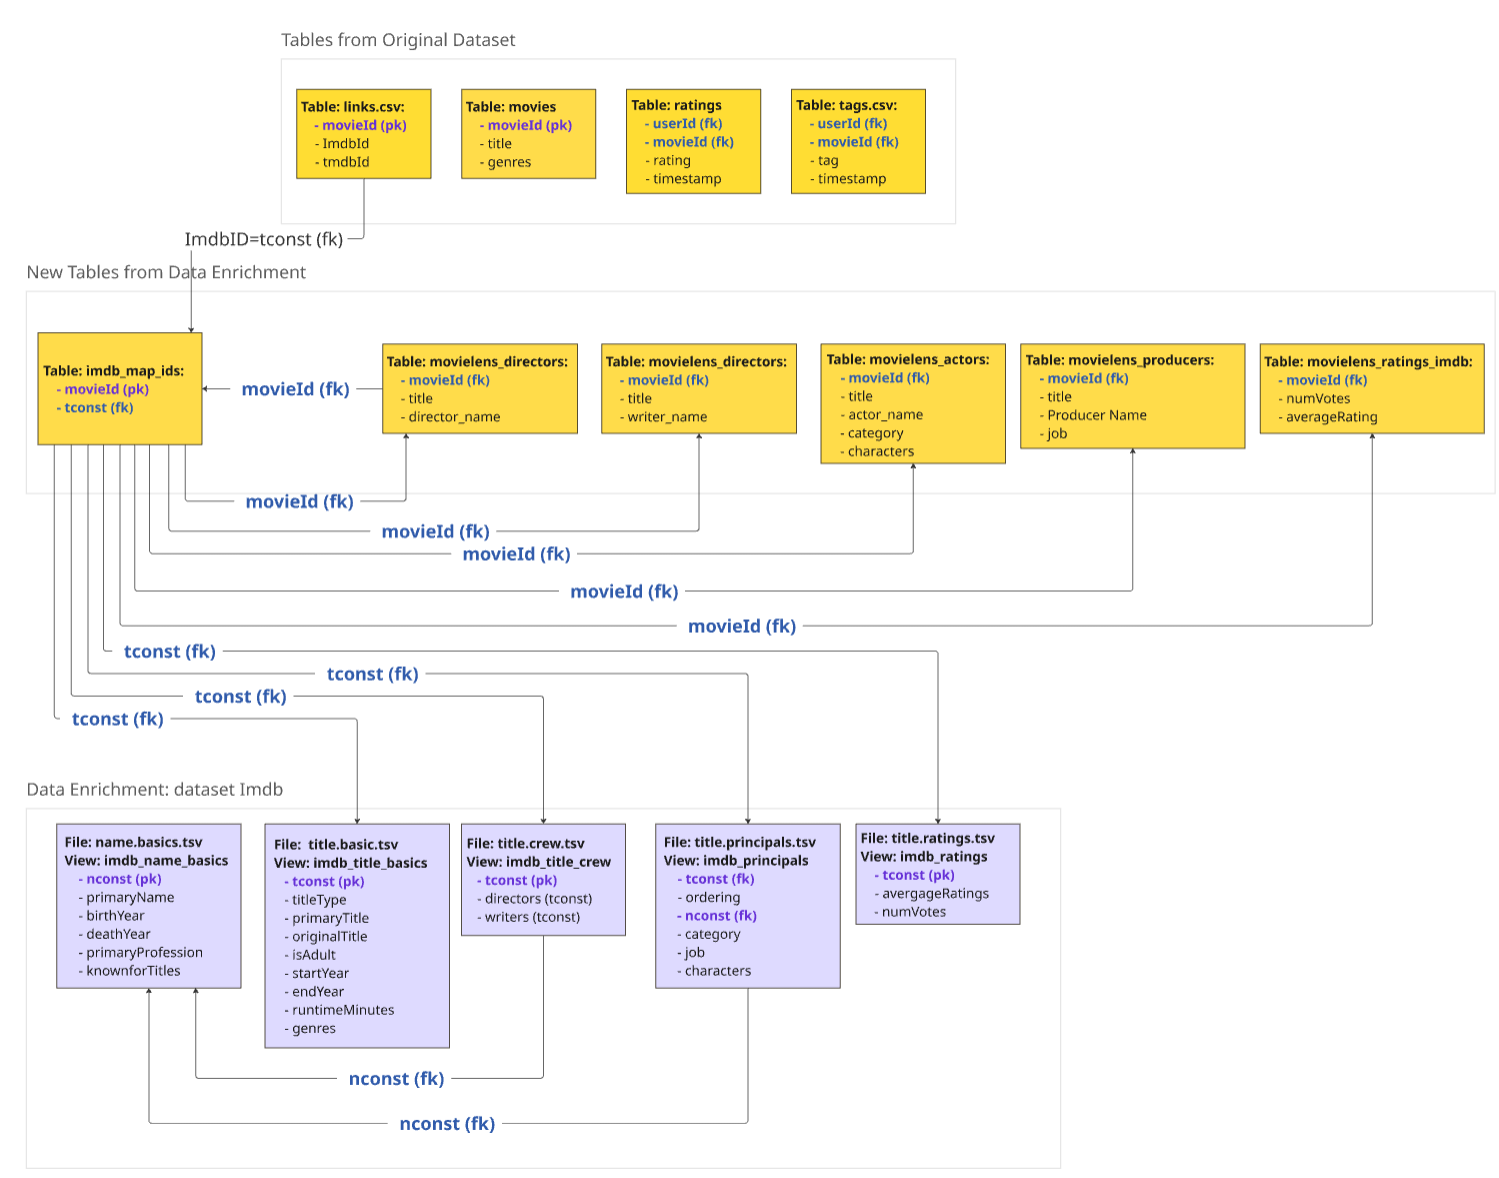

In [69]:
# List of all tables in the database
con.sql("""
SELECT table_name, table_type
FROM information_schema.tables
""").df()

,table_name,table_type
0,imdb_principals_writers,BASE TABLE
1,links,BASE TABLE
2,movielens_actors,BASE TABLE
3,movielens_directors,BASE TABLE
4,movielens_main_producers,BASE TABLE
5,movielens_ratings_imdb,BASE TABLE
6,movielens_writers,BASE TABLE
7,movies,BASE TABLE
8,ratings,BASE TABLE
9,tags,BASE TABLE


#### Some notes about the IMBD database

`Name_basics`:
- There are 14.8M rows but only 11.4M unique names. On average, each name is associated with 1.3 professions.
- There’s 46 distinct professions, part of the top3 we find: “Actor” with 3.4M entries (27%), “Actress” with 2.1M entries (14%), and “Producer” with 1.3M (9%).

`Title_basics`:
- IMBD database is composed by 12M movies, which is 14x bigger than MovieLens database (around 87K movies)

`Title_crew`:
- Out of the 12M movies, there are 980K unique directors and 1.5M unique writers. These numbers are actually bigger than the ones found in the first table `name_basics` (804K unique directors and 983K unique writers) - most probably because on that table is being shown only the “primary profession”

`Title_principals`: 
- There are two columns with very similar information (“category” and “job” - i.e. for nm0374658, category was “cinematographer”, and “job” was “director of photography”)
- However, not all jobs are equal (or similar) for example:
- Within “writers” there are “screenplay”, “story” or “novel”
- Within “directors” there are “supervising director”, “segment director” or “series director”

`Title_ratings`:
- There are 16.4M titles , each rated between 0-10, with an average rating of 6.9 and up to 3.1M ratings in a single title. 
- On average, each title has 1025 ratings.
- The ratings are left-skewed shaped.
 
#### Data enrichment (joining the database of “movieLens” with “imbd”)
- Comparison between 100K and 33M databases:
- Higher number of movies with imbd link: 9.7K vs. 86.5K
- Higher % of movies without a director named: 0.3% vs. 4%
- The top10 directors list is completely different between databases: in the 100K one, Woody Allen takes the lead with only 48 movies directed; however in the 33M one, Georges Méliès takes the lead with 116 movies directed.
- Similar average of directors per title: around 1.14
- Higher % of movies without a writer named: 2% vs. 9%
- With the top10 writers we see a similar scenario with the list being different between databases. Something curious: William Shakespeare has 32 titles in 100K, and leads the 33M one with 153 titles; Ben Hecht comes in #7 in the 100K also with 32 titles, while in the 33M one comes in #2 with 114 titles.
- In the 100K database, the title with the most writers is “Mulan (1998)” with 32 whilst in the 33M one is “Adventure Time: Islands (2017)” with 63
- Out of the top20 actors with the highest number of titles, only two are in both datasets: Samuel L Jackson and Michael Caine
- Fun fact: the top3 actors of 33M database is led by voice actors from the classic era of animation: two from Disney (Nash = Donald Duck; Colvig = Goofy) and one from Warner Bros (Bugs Bunny or Daffy Duck, among others).
- The most common name is different: Jack (115 titles) vs. Anna (785)
 
#### Comparison between IMBD and MovieLens
- The top1 best ranked movie lens is the top1 best ranked movie in imbd (“Shawshank Redemption, The (1994)”), however “Forrest Gump (1994)” which ranks #2 in movie lens, only ranks #5 in Imbd. 
- Out of the top20 movies, only 7 were published in ‘90s in IMBD. In Movie Lens this number was 12 out of 20. Is MovieLens losing its relevance in this 21st century?


#### Fechar a ligação

In [70]:
con.close()
print("Ligação fechada.")

Ligação fechada.
